# Tesla Stock Price Prediction, Bayesian Optimization
### Second Semester Capstone

This notebook is an implementation of a Bayesian optimization using the scikit-optimize library

#### Notes:

When testing multi-step prediction with 365 days, a lower percent train was found to produce better results. (70% train versus 80% train). Also got better results when using more recent data. I grabbed a new Tesla stock CSV from Yahoo Finance that now leads up to 12/31/2021. Prior tests with the previous data set yielded results of about 69% error at best

In [1]:
import pandas as pd
import numpy as np
#tf.compat.v1.disable_v2_behavior()
from math import sqrt, floor, ceil, isnan, nan
from matplotlib import pyplot
from statistics import mean

#imports we know we'll need
import skopt
# !pip install scikit-optimize if  necessary
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence  

from tensorflow.python.keras import backend as K

# Import keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Flatten, RepeatVector, Dropout
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.preprocessing import MinMaxScaler

# LSTM Application

## Preparing Data

In [2]:
# Loading Preprocessed Data File
df = pd.read_csv("preprocessedGM_MoreRecent.csv", parse_dates=['Date'],index_col=0)
df.dropna(inplace=True)
df = df.loc[(df.index >= '2019-01-01')]

print(df.shape)
df.head(1)

(757, 16)


,Open,High,Low,Close,Adj Close,Volume,Tesla Trend,Musk Trend,GM Trend,EV Trend,Coronavirus Trend,Month,Day of the Month,Day of the Week,Day of the Year,Year
Date,,,,,,,,,,,,,,,,
2019-01-02,32.849998,33.810001,32.41,33.639999,31.893358,7662300.0,37.0,8.7,55.8,34.0,0.0,1,2,2,2,2019


In [3]:
df.drop(df.columns.difference(['Date','Close','Tesla Trend','Musk Trend','GM Trend','EV Trend','Coronavirus Trend','Month','Day of the Month','Day of the Week','Day of the Year','Year']), 1, inplace=True)
df.head(3)

C:\Users\thoma\AppData\Local\Temp\ipykernel_17312\37563983.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['Date','Close','Tesla Trend','Musk Trend','GM Trend','EV Trend','Coronavirus Trend','Month','Day of the Month','Day of the Week','Day of the Year','Year']), 1, inplace=True)


,Close,Tesla Trend,Musk Trend,GM Trend,EV Trend,Coronavirus Trend,Month,Day of the Month,Day of the Week,Day of the Year,Year
Date,,,,,,,,,,,
2019-01-02,33.639999,37.00,8.7,55.80,34.00,0.0,1,2,2,2,2019
2019-01-03,32.250000,32.19,7.1,55.18,17.68,0.0,1,3,3,3,2019
2019-01-04,33.330002,28.86,9.7,55.18,22.44,0.0,1,4,4,4,2019


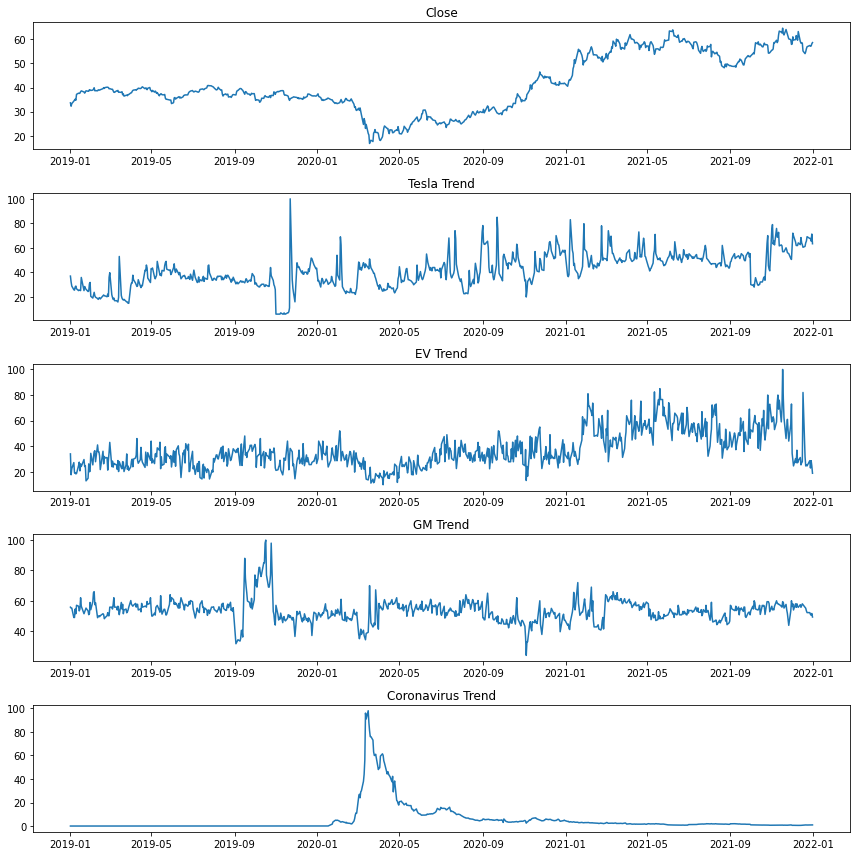

In [4]:
dates = df.index.to_numpy()
pyplot.figure(figsize=(12,12))
pyplot.subplot(5, 1, 1)
pyplot.plot(dates, df["Close"], label="Close")
pyplot.title("Close")
pyplot.subplot(5, 1, 2)
pyplot.plot(dates, df["Tesla Trend"], label="Tesla Trend")
pyplot.title("Tesla Trend")
pyplot.subplot(5, 1, 3)
pyplot.plot(dates, df["EV Trend"], label="EV Trend")
pyplot.title("EV Trend")
pyplot.subplot(5, 1, 4)
pyplot.plot(dates, df["GM Trend"], label="GM Trend")
pyplot.title("GM Trend")
pyplot.subplot(5, 1, 5)
pyplot.plot(dates, df["Coronavirus Trend"], label="Coronavirus Trend")
pyplot.title("Coronavirus Trend")
pyplot.tight_layout()
pyplot.show()

### Function For Converting Time Series Data For Supervised Learning

In [5]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, col_names, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_temp.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df_temp.shift(-i))
        if i == 0:
            names += [('%s(t)' % (col_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
  value = dataset[i] - dataset[i - interval]
  diff.append(value)
 return pd.Series(diff)

### Conversion of Time Series Data

In [7]:
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features, makes it easier for the model to train on
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [8]:
n_in = 200                # timesteps for input           
n_out = 365            # timesteps for output
n_predict = 1          # n_predict = (number of data points you want to predict) / n_out
percent_train = 0.70    # percent as decimal

# frame as supervised learning
reframed = series_to_supervised(scaled, df.columns, n_in, n_out)
# Drop Columns of Variables We Aren't Predicting
for i in range(1, n_out):
    reframed.drop(reframed.loc[:, ('Tesla Trend(t+%i)' %(i)):('Year(t+%i)' %(i))], axis=1, inplace=True)
reframed.drop(reframed.loc[:, 'Tesla Trend(t)':'Year(t)'], axis=1, inplace=True)
print(reframed.shape)
reframed.head()

(193, 2565)


,Close(t-200),Tesla Trend(t-200),Musk Trend(t-200),GM Trend(t-200),EV Trend(t-200),Coronavirus Trend(t-200),Month(t-200),Day of the Month(t-200),Day of the Week(t-200),Day of the Year(t-200),...,Close(t+355),Close(t+356),Close(t+357),Close(t+358),Close(t+359),Close(t+360),Close(t+361),Close(t+362),Close(t+363),Close(t+364)
200,0.352228,0.329787,0.069602,0.418421,0.267643,0.0,0.0,0.033333,0.50,0.000000,...,0.904622,0.888308,0.899812,0.863836,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412
201,0.323154,0.278617,0.053297,0.410263,0.086551,0.0,0.0,0.066667,0.75,0.002747,...,0.888308,0.899812,0.863836,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412,0.850450
202,0.345744,0.243191,0.079792,0.410263,0.139370,0.0,0.0,0.100000,1.00,0.005495,...,0.899812,0.863836,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412,0.850450,0.857561
203,0.367287,0.211702,0.064506,0.328684,0.192188,0.0,0.0,0.200000,0.00,0.013736,...,0.863836,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412,0.850450,0.857561,0.925329
204,0.376699,0.207766,0.051259,0.328684,0.101642,0.0,0.0,0.233333,0.25,0.016484,...,0.823259,0.815938,0.832462,0.830788,0.818657,0.872412,0.850450,0.857561,0.925329,0.944154


In [9]:
y_vals = reframed.iloc[:,n_out*-1:].values
x_vals = reframed.iloc[:,:n_out*-1].values
# split into train, test, and prediction sets
n_train = floor((len(x_vals)-n_predict) * percent_train)

# split into input and outputs
train_X, train_y = x_vals[:n_train, :], y_vals[:n_train, :]
test_X, test_y = x_vals[n_train:len(x_vals)-n_predict, :], y_vals[n_train:len(y_vals)-n_predict, :]
predict_X, predict_y = x_vals[len(x_vals)-n_predict:, :], y_vals[len(y_vals)-n_predict:, :]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((n_train, n_in, len(df.columns)))
test_X = test_X.reshape((test_X.shape[0], n_in, len(df.columns)))
predict_X = predict_X.reshape((n_predict, n_in, len(df.columns)))

predict_y_mean = np.mean(predict_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, predict_X.shape, predict_y.shape)

(134, 200, 11) (134, 365) (58, 200, 11) (58, 365) (1, 200, 11) (1, 365)


## Running Model

### Function For Building Model

In [10]:
# Design Network
def build_model(learning_rate, LSTM1, LSTM2, dropout1, dropout2, n_out):
    model = Sequential()

    model.add(BatchNormalization(name = "batch_norm_0", input_shape = (train_X.shape[1], train_X.shape[2])))

    model.add(LSTM(LSTM1, name='lstm_1', return_sequences=True))
    model.add(Dropout(dropout1, name='dropout_1'))
    model.add(BatchNormalization(name='batch_norm_1'))

    model.add(LSTM(LSTM2, name='lstm_2', return_sequences=False))
    model.add(Dropout(dropout2, name='dropout_2'))

    model.add(Dense(n_out, name='dense', activation="linear", kernel_constraint=NonNeg()))

    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mae', metrics=['accuracy'])

    return model

### Bayesian Optimization

based on https://medium.com/@crawftv/parameter-hyperparameter-tuning-with-bayesian-optimization-7acf42d348e1

In [11]:

dim_learning_rate = Real(low=0.0001, high=0.8, prior='uniform', name='learning_rate')
dim_LSTM1 = Integer(low=1, high=300, name='LSTM1')
dim_LSTM2 = Integer(low=1, high=300, name='LSTM2')
dim_dropout1 = Real(low=0.0000, high=0.8, prior='uniform', name='dropout1')
dim_dropout2 = Real(low=0.0000, high=0.8, prior='uniform', name='dropout2')
dim_batch_size = Integer(low=1, high=600, name='batch_size')
dim_patience = Integer(low=10,high=100, name="patience")
dim_num_epochs = Integer(low=10,high=200, name="num_epochs")

dimensions = [
    dim_learning_rate,
    dim_LSTM1,
    dim_LSTM2,
    dim_dropout1,
    dim_dropout2,
    dim_batch_size,
    dim_patience,
    dim_num_epochs
]
default_parameters = [
    [0.05, 10, 5, 0.3, 0.2, 128, 10, 100],
    [0.05070040716996712,9,5,0.2981292286447875,0.20196385462236377,130,20,100],
    [0.14900790534917321,227,20,0.1332896435164779,0.25310540191204833,7,82,151],
    [0.1723443596701473, 206, 182, 0.8, 0.47091493758924624, 131, 65, 172]
]

In [12]:

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, LSTM1, LSTM2, dropout1, dropout2, batch_size, patience, num_epochs):

    model = build_model(
        learning_rate=learning_rate,
        LSTM1=LSTM1,
        LSTM2=LSTM2,
        dropout1=dropout1,
        dropout2=dropout2,
        n_out=n_out,
    )
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)
    history = model.fit(x=train_X, y=train_y, 
        epochs=num_epochs, 
        batch_size=batch_size, 
        validation_data=(test_X, test_y), 
        shuffle=False,
        verbose=0, 
        callbacks=[early_stopping]
    )
    #return the minimum validation mae for the patience period
    mae = np.nanmin(history.history['val_loss'][-1*patience:])

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    del early_stopping
    del history
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    
    # the optimizer aims for the lowest score
    if isnan(mae):
        return 9999.9999
    normalized_mae = mae/predict_y_mean
    return normalized_mae

In [13]:
gp_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    n_calls=25,
    n_jobs=-1,
    kappa=1.96,    # default is 1.96, lower values = more exploitation, higher = more exploration
    noise=1e-5,
    acq_optimizer="lbfgs",
    x0=default_parameters,
    n_initial_points=10,
    verbose=True
)

Iteration No: 1 started. Evaluating function at provided point.
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 79.7121
Function value obtained: 0.1690
Current minimum: 0.1516
Iteration No: 2 started. Evaluating function at provided point.
Iteration No: 2 ended. Evaluation done at provided point.
Time taken: 10.0642
Function value obtained: 0.3038
Current minimum: 0.1516
Iteration No: 3 started. Evaluating function at provided point.
Iteration No: 3 ended. Evaluation done at provided point.
Time taken: 11.2953
Function value obtained: 0.3667
Current minimum: 0.1516
Iteration No: 4 started. Evaluating function at provided point.
Iteration No: 4 ended. Evaluation done at provided point.
Time taken: 8.3745
Function value obtained: 0.3165
Current minimum: 0.1516
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.2198
Function value obtained: 0.3087
Current minimum: 0.1516
Iteration No: 6 

C:\Users\thoma\AppData\Local\Temp\ipykernel_17312\1365542490.py:23: RuntimeWarning: All-NaN axis encountered
  mae = np.nanmin(history.history['val_loss'][-1*patience:])


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 14.4286
Function value obtained: 9999.9999
Current minimum: 0.1516
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 590.2948
Function value obtained: 0.2524
Current minimum: 0.1516
Iteration No: 13 started. Evaluating function at random point.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 8.7536
Function value obtained: 1.9585
Current minimum: 0.1516
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 74.4299
Function value obtained: 0.1771
Current minimum: 0.1516
Iteration No: 15 started. Evaluating function at random point.
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 10.5654
Function value obtained: 0.1591
Current minimum: 0.1516
Iteration No: 16 started. Evaluating function at random point.
Iteration No: 16 

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

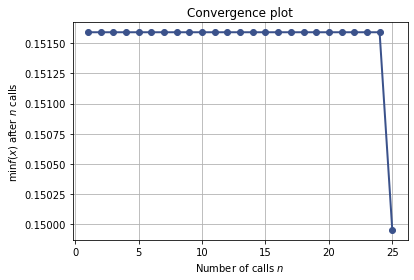

In [14]:
plot_convergence(gp_result)

In [15]:
gp_result.x

[0.09020294903491917,
 131,
 104,
 0.5403923824839899,
 0.32774414270286845,
 130,
 40,
 144]

In [16]:
res_df = pd.DataFrame(data=gp_result.x_iters, columns=['Learning Rate','Nodes 1','Nodes 2','Dropout 1','Dropout 2','Batch Size','Patience','Epochs'])
res_df['MAE'] = gp_result.func_vals
res_df.sort_values('Normalized MAE', inplace=True) 
res_df.head(15)

,Learning Rate,Nodes 1,Nodes 2,Dropout 1,Dropout 2,Batch Size,Patience,Epochs,MAE
24,0.090203,131,104,0.540392,0.327744,130,40,144,0.149953
0,0.050000,10,5,0.300000,0.200000,128,10,100,0.151591
19,0.078805,66,53,0.434037,0.288800,129,29,119,0.156488
17,0.110489,117,101,0.577788,0.345203,129,35,141,0.159124
21,0.113558,106,96,0.544175,0.271438,129,22,138,0.160697
3,0.172344,206,182,0.800000,0.470915,131,65,172,0.168997
18,0.126640,136,119,0.636950,0.369093,130,43,144,0.171294
16,0.130305,237,36,0.111425,0.296443,6,87,158,0.177054
2,0.149008,227,20,0.133290,0.253105,7,82,151,0.185309
23,0.104213,219,153,0.165374,0.481045,5,70,143,0.194503


## Results

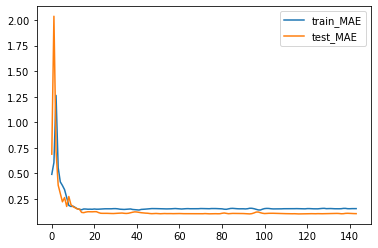

MAE = 7.8824 NMAE = 0.1600 NRMSE = 0.1945

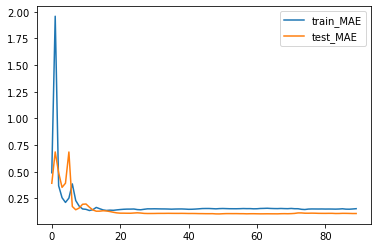

MAE = 7.8228 NMAE = 0.1588 NRMSE = 0.1928

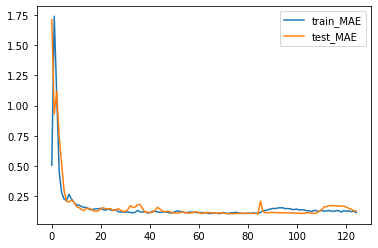

MAE = 7.5872 NMAE = 0.1540 NRMSE = 0.1864

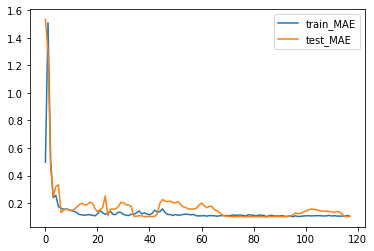

MAE = 7.3986 NMAE = 0.1501 NRMSE = 0.1826

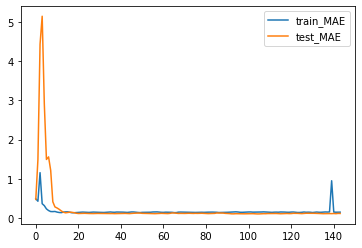

MAE = 8.3361 NMAE = 0.1692 NRMSE = 0.2053

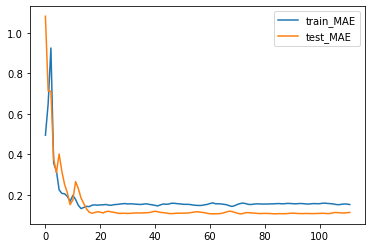

MAE = 7.7961 NMAE = 0.1582 NRMSE = 0.1931Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 200, 11)           44        
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 131)          74932     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 131)          0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 200, 131)          524       
_________________________________________________________________
lstm_2 (LSTM)                (None, 104)               98176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 104)               0         
_________________________________________________________________
dense (Dense)

In [18]:
num_trials = 6
best_nmae = 9999.9999
best_model = None
scaler.fit(df["Close"].values.reshape(-1,1))
inv_y = scaler.inverse_transform(predict_y).reshape(n_out*n_predict)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    patience=gp_result.x[6], 
    restore_best_weights=True
)
for t in range(num_trials):
    print("Trial %i" %(t+1))
    model = build_model(
        learning_rate=gp_result.x[0], 
        LSTM1=gp_result.x[1],
        LSTM2=gp_result.x[2],
        dropout1=gp_result.x[3], 
        dropout2=gp_result.x[4],
        n_out=n_out
    )
    history = model.fit(
        x=train_X,
        y=train_y,
        epochs=gp_result.x[7], 
        batch_size=gp_result.x[5],
        validation_data=(test_X, test_y), 
        shuffle=False, 
        verbose=0,
        callbacks=[early_stopping])
    pyplot.figure()
    pyplot.plot(history.history['loss'], label='train_MAE')
    pyplot.plot(history.history['val_loss'], label='test_MAE')
    pyplot.legend()
    pyplot.show()

    # Make Prediction
    yhat = model.predict(predict_X)

    inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(n_out*n_predict)
    # calculate RMSE and NRMSE
    normalized_rmse = sqrt(tf.keras.metrics.mean_squared_error(inv_y, inv_yhat))/mean(inv_y)
    mae = tf.keras.metrics.mean_absolute_error(inv_y, inv_yhat)
    normalized_mae = mae/tf.math.reduce_mean(inv_y)
    print('MAE = %.4f NMAE = %.4f NRMSE = %.4f' % (mae, normalized_mae, normalized_rmse))
    
    if normalized_mae < best_nmae:
        best_nmae = normalized_mae
        best_model = model
    else:
        del model
print()
print(best_model.summary())

In [19]:
# Make Prediction
yhat = best_model.predict(predict_X)
inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1)).reshape(n_out*n_predict)
# calculate RMSE and NRMSE
normalized_rmse = sqrt(tf.keras.metrics.mean_squared_error(inv_y, inv_yhat))/mean(inv_y)
mae = tf.keras.metrics.mean_absolute_error(inv_y, inv_yhat)
normalized_mae = mae/tf.math.reduce_mean(inv_y)
print('MAE = %.4f NMAE = %.4f NRMSE = %.4f' % (mae, normalized_mae, normalized_rmse), end="")

MAE = 7.3986 NMAE = 0.1501 NRMSE = 0.1826

In [20]:
predictDates = dates[len(dates)-(n_out*n_predict):]
numQuarters = floor(n_out / 90)
quarter = floor(n_out/numQuarters)
print(quarter)
maxes = [predictDates[np.argmax(inv_yhat[0:quarter], axis=0)]]
maxes_actual = [predictDates[np.argmax(inv_y[0:quarter], axis=0)]]
for i in range(0, numQuarters-1):
    maxes.append(predictDates[np.argmax(inv_yhat[quarter*(i+1):quarter*(i+2)-1], axis=0)+quarter*(i+1)])
    maxes_actual.append(predictDates[np.argmax(inv_y[quarter*(i+1):quarter*(i+2)-1], axis=0)+quarter*(i+1)])

91


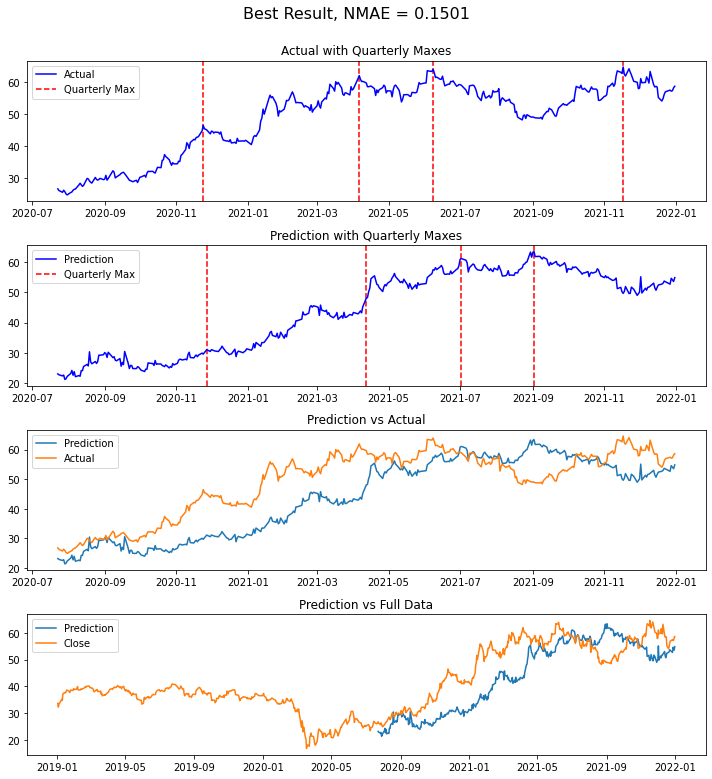

In [21]:
# Plot of Prediction vs Actual
pyplot.figure(figsize=(10,11))

pyplot.suptitle("Best Result, NMAE = %.4f\n" %(normalized_mae), fontsize=16)
pyplot.subplot(4, 1, 1)
pyplot.plot(predictDates, inv_y, color='b', label="Actual", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes_actual[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes_actual[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Actual with Quarterly Maxes")

pyplot.subplot(4, 1, 2)
pyplot.plot(predictDates, inv_yhat, color='b', label="Prediction", zorder=2)
# Adding dashed lines for the quarterly maximums
pyplot.axvline(x=maxes[0], color='r', linestyle='--', label='Quarterly Max', zorder=1)
for xc in maxes[1:]:
    pyplot.axvline(x=xc, color='r', linestyle='--', zorder=1)
pyplot.legend(loc='upper left')
pyplot.title("Prediction with Quarterly Maxes")

pyplot.subplot(4,1,3)
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.plot(predictDates, inv_y, label="Actual")
pyplot.legend(loc='upper left')
pyplot.title("Prediction vs Actual")

pyplot.subplot(4,1,4)
pyplot.plot(predictDates, inv_yhat, label="Prediction")
pyplot.plot(dates, df["Close"], label="Close")
pyplot.legend(loc='upper left')
pyplot.title("Prediction vs Full Data")

pyplot.tight_layout()
pyplot.show()

In [22]:
# Printing the dates of each quarterly maximum
for i in range(len(maxes)):
    print("Q%i Max: %s" %(i+1, maxes[i]))
    print("Q%i Actual Max: %s" %(i+1, maxes_actual[i]))
    print("Diff: %s" %abs((maxes_actual[i]-maxes[i]).astype('timedelta64[D]')))

Q1 Max: 2020-11-27T00:00:00.000000000
Q1 Actual Max: 2020-11-24T00:00:00.000000000
Diff: 3 days
Q2 Max: 2021-04-12T00:00:00.000000000
Q2 Actual Max: 2021-04-06T00:00:00.000000000
Diff: 6 days
Q3 Max: 2021-07-02T00:00:00.000000000
Q3 Actual Max: 2021-06-08T00:00:00.000000000
Diff: 24 days
Q4 Max: 2021-09-02T00:00:00.000000000
Q4 Actual Max: 2021-11-17T00:00:00.000000000
Diff: 76 days


In [24]:
from datetime import date

best_model.save('SavedModel_%s_%.4f.h5' % (date.today(), normalized_rmse))